In [1]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from scipy import stats
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics

In [2]:
%matplotlib inline

In [3]:
# the change_in data in the last row has been generated manually using equation...next time do it during data extraction
data_source_path = "F:\deep lerning project\data\FinalData\d3.wordpress_phpbb23.label.normalized_density.csv"

# for slicing the necessary columns from the source file...directly related to source data columns
label_col_start = 0
feature_col_start = 8

# I have many labels but here is the col that contains 'changed_ever_class'
class_label_col = 2 # class is in col2

#Optional
n_folds = 10 #set value of k of k-fold

In [4]:
# Some configurations
# set only one to true...
select_model_based_on_error_rate = False
select_model_based_on_auc = True
#---------------------------------

In [5]:
def get_feature_and_label():
    # read the data file
    # return features and labels
    
    file_change_df = pd.read_csv(data_source_path)
    
    X = file_change_df.iloc[:,feature_col_start:]
    #print(X.shape)
    #print(X)
    
    y_all_labels = file_change_df.iloc[:,label_col_start:feature_col_start] # all available labels 
    #print(type(y_all_labels))
    #print(y_all_labels)
    y = y_all_labels.iloc[:,class_label_col] # take the manually created changed_in_release_inerval col only
   # y = pd.Series.to_frame(y) # y is a series...convert it to dataframe again--- not necessary...series will do
    #print(y.head())
    #print(type(y))
    
    #print(y.shape)
    #print(y)
    
    return X, y

In [6]:
def get_train_test_split(X, y, nsplits = 1, testSize = 0.2):

    sss = StratifiedShuffleSplit(n_splits=nsplits, test_size=testSize)
    
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index] # X.iloc[index] because its pandas dataframe.so..iloc
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
    return X_train, y_train, X_test, y_test

In [7]:
def show_evaluation_error_report(eval_error_rates):
    
    eval_error_rate_avg = sum(eval_error_rates)/len(eval_error_rates)
    model_std = np.std(eval_error_rates)
    
    print("Evaluation Errors:", eval_error_rates)
    print('Evaluation error rate average:', eval_error_rate_avg, '\nModel\'s standard deviation:', model_std)

In [8]:
def prediction(model, X, y):
    y_predicted = model.predict(X)
    error_rate = sum(y_predicted != y)/len(y_predicted)
    #print("predicted:", y_predicted)
    
    return y_predicted, error_rate

In [9]:
def get_auc(model, X, y):
    # this auc calculation is different from the auc calculation for tensorflow DNNclassifier
    
    y = y.as_matrix() # convert series data to numpy array
    
    y_proba = model.predict_proba(X) # gives probability of each class
    
    #print("y_prob:", y_proba.shape, "val:", y_proba)
    
    auc = metrics.roc_auc_score(y, y_proba[:,1]) #y_proba has 2cols..take only the score of the positive class..i.e. in index 1
    #print("Auc:", auc)
    
    '''
    #This one also works but not needed
    fpr, tpr, thresholds = metrics.roc_curve(y, y_proba[:,1])
    auc2 = metrics.auc(fpr, tpr)
    print("AUC2:", auc2, "fpr:", fpr, "tpr:", tpr)
    '''
    
    return auc

In [10]:
def create_model_evaluate_k_fold(X_train_0,y_train_0):
    
    # this method is a little different from other models' same method
    
    knn_test_number = 1 #for keeping track only
    k = [1, 3, 5, 7, 11]
    
    eval_error_rates = []
    folding_session = 0

    min_error_rate = float("inf")
    max_auc = float("-inf")


    # Now split the trainig data into train and evaluation sets
    skf = StratifiedKFold(n_splits = n_folds)  # n_folds: global

    for train_index, test_index in skf.split(X_train_0,y_train_0):
        # total 10 folds
        bestk = 0
        min_current_fold_error = float("inf")


        # 9 folds traning
        X_train = X_train_0.iloc[train_index]
        y_train = y_train_0.iloc[train_index]

        # 1 fold testing
        X_test = X_train_0.iloc[test_index]
        y_test = y_train_0.iloc[test_index]

        for n in k:
            # create a new model
            my_model = KNeighborsClassifier(n_neighbors=n)

            # train the model
            my_model.fit(X_train, y_train)

            # evaluate the model
            y_predicted, error_rate = prediction(my_model, X_test, y_test)

            # calculate auc
            auc_evaluation = get_auc(my_model, X_test, y_test) # X_test, y_test are evaluation folds

            #----
            print('Folding Session', folding_session, 'k=',n, "AUC:", auc_evaluation, "Accuracy:", 1-error_rate, 'Error_rate:', error_rate)
            #----

            if select_model_based_on_error_rate:
                if error_rate < min_error_rate:
                    best_model = my_model # update the global best model among all folds
                    min_error_rate = error_rate
                    bestk = n
                    print('*The last k is the best k so far...')
                    print("Selecting model based on min_error_rate.")

            if select_model_based_on_auc:
                if auc_evaluation > max_auc:
                    best_model = my_model # update the global best model among all folds
                    max_auc = auc_evaluation # update the max_auc
                    bestk = n
                    print('*The last k is the best k so far...')
                    print("Selecting model based on max_auc.")     

            # this one is not related to model selection...for calculating std
            if error_rate < min_current_fold_error:  # for preparing std by taking the lowest error rate for this fold
                min_current_fold_error = error_rate


        eval_error_rates.append(min_current_fold_error)

        folding_session = folding_session + 1

    return best_model, eval_error_rates

In [11]:
def calculate_performance_metrics(cnf_matrix):
    
    TP = cnf_matrix[1,1]
    TN = cnf_matrix[0,0]
    FP = cnf_matrix[0,1]
    FN = cnf_matrix[1,0]
    
    
    # Sensitivity, hit rate, recall, or true positive rate
    TPR_recall = TP/(TP+FN) # Recall
    # Specificity or true negative rate
    TNR = TN/(TN+FP) # **
    # Precision or positive predictive value
    PPV_precision = TP/(TP+FP) # precision
    # Negative predictive value
    NPV = TN/(TN+FN) #**
    # Fall out or false positive rate
    FPR_false_positive = FP/(FP+TN)
    # False negative rate
    FNR_false_negative = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP) # **

    # Overall accuracy
    accuracy = (TP+TN)/(TP+FP+FN+TN)
    f_measure = 2/((1.0/TPR_recall) + (1.0/PPV_precision)) #https://en.wikipedia.org/wiki/F1_score
    
    # ** some extra values are calculated but not returned
    return TPR_recall, PPV_precision, FPR_false_positive, FNR_false_negative, accuracy, f_measure

In [12]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [13]:
def show_confusion_matrix(cnf_matrix, class_names):
    # show cmap of confusion metrics
    np.set_printoptions(precision=2) # settings for printing floating point values
    
    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')

    plt.show()

In [14]:
def main():
    
    X, y = get_feature_and_label()
    X_train_0, y_train_0, X_test_final, y_test_final = get_train_test_split(X,y)

    best_model, k_fold_eval_error_rates = create_model_evaluate_k_fold(X_train_0, y_train_0)
    show_evaluation_error_report(k_fold_eval_error_rates)

    #predict using the best model
    y_predicted, error_rate = prediction(best_model, X_test_final, y_test_final)

    auc_final = get_auc(best_model, X_test_final, y_test_final)

    print("\nFinal Test>> AUC:", auc_final, "Accuracy:", 1-error_rate, "Final Error_rate:", error_rate)
    
    cnf_matrix = confusion_matrix(y_test_final, y_predicted)
    # Calculate performane metrics
    TPR_recall, PPV_precision, FPR_false_positive, FNR_false_negative, accuracy, f_measure = calculate_performance_metrics(cnf_matrix)
    
    print("F-measure:", f_measure, "Accuracy:",accuracy, "Recall:", TPR_recall, "Precision:", PPV_precision, "False Positive Rate:", FPR_false_positive, "False Negative Rate:", FNR_false_negative)
    
    
    # show cmap of confusion metrics
    class_names = ['0','1'] # class names in order.. 1st index for class whose label is 0, 2nd index for class whose label is 1......
    show_confusion_matrix(cnf_matrix, class_names)

Folding Session 0 k= 1 AUC: 0.665934931892 Accuracy: 0.834183673469 Error_rate: 0.165816326531
*The last k is the best k so far...
Selecting model based on max_auc.
Folding Session 0 k= 3 AUC: 0.76376760318 Accuracy: 0.874149659864 Error_rate: 0.125850340136
*The last k is the best k so far...
Selecting model based on max_auc.
Folding Session 0 k= 5 AUC: 0.79188712522 Accuracy: 0.87925170068 Error_rate: 0.12074829932
*The last k is the best k so far...
Selecting model based on max_auc.
Folding Session 0 k= 7 AUC: 0.814297507813 Accuracy: 0.87925170068 Error_rate: 0.12074829932
*The last k is the best k so far...
Selecting model based on max_auc.
Folding Session 0 k= 11 AUC: 0.824474785974 Accuracy: 0.875 Error_rate: 0.125
*The last k is the best k so far...
Selecting model based on max_auc.
Folding Session 1 k= 1 AUC: 0.647810424406 Accuracy: 0.832482993197 Error_rate: 0.167517006803
Folding Session 1 k= 3 AUC: 0.735039642334 Accuracy: 0.865646258503 Error_rate: 0.134353741497
Folding 

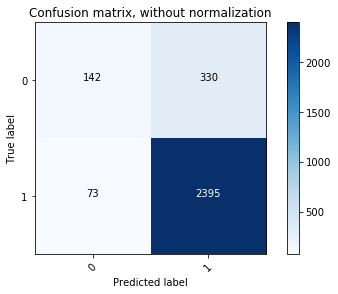

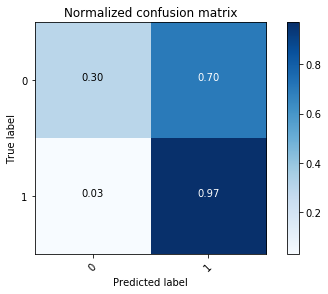

In [15]:
main()